<a href="https://colab.research.google.com/github/harrybaines/ml-resources/blob/main/nlp/BERT_text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bidirectional Encoder Representations from Transformers


Reference post: https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

In [5]:
# BERT consists of several stacked Transformer encoders
# Each Transformer has 2 sub-layers: self-attention layer and a feed-forward layer

In [6]:
%%capture
!pip install transformers

In [7]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

## Import Data

Get the data [here](https://www.kaggle.com/sainijagjit/bbc-dataset).

In [8]:
datapath = f'./bbc-text.csv'
df = pd.read_csv(datapath)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


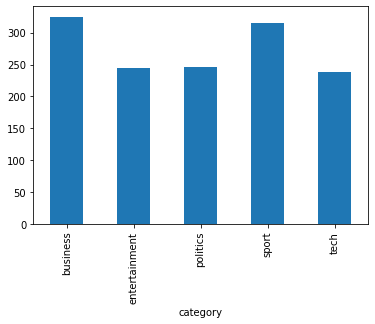

In [9]:
df.groupby(['category']).size().plot.bar()

In [10]:
from transformers import BertTokenizer # transformations for BERT

tokenizer = BertTokenizer.from_pretrained('bert-base-cased') # good pre-trained BERT tokenizer for English text
# also bert-base-multilingual-cased

example_text = 'I will watch Memento tonight'
bert_input = tokenizer(
    example_text,
    padding='max_length', # pad each sequence to maximum specified length
    max_length=10,  # maximum sequence length
    truncation=True, # truncate sequence if more than max_length
    return_tensors="pt" # pytorch tensors
)

In [11]:
print(bert_input['input_ids']) # id representation of each token
print(bert_input['token_type_ids']) # binary mask which identifies which sequence a token belongs to
print(bert_input['attention_mask']) # binary mask which identifies whether a word is real or just padding

tensor([[  101,   146,  1209,  2824,  2508, 26173,  3568,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


In [12]:
example_text = tokenizer.decode(bert_input.input_ids[0])
example_text

'[CLS] I will watch Memento tonight [SEP] [PAD] [PAD]'

In [13]:
# single sequence, so all 0 (optional input) for text classification task
example_text = tokenizer.decode(bert_input.token_type_ids[0])
example_text

'[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [14]:
# mask is 1 for [CLS], [SEP] or any other word, 0 for [PAD]
example_text = tokenizer.decode(bert_input.attention_mask[0])
example_text

'[unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [PAD] [PAD]'

## Build Dataset

In [15]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {
    'business': 0,
    'entertainment': 1,
    'sport': 2,
    'tech': 3,
    'politics': 4
}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['category']]
        self.texts = [
            tokenizer(
                text, 
                padding='max_length',
                max_length=512,
                truncation=True,
                return_tensors="pt"
            )
            for text in df['text']
        ] # transform input texts to format BERT expects

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [16]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1096 137 137


## Model Building

In [17]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        # pooled_output: embedding vector of [CLS] token (used for classifier)
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [18]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 548/548 [02:01<00:00,  4.52it/s]


Epochs: 1 | Train Loss:  0.800                 | Train Accuracy:  0.253                 | Val Loss:  0.775                 | Val Accuracy:  0.350


100%|██████████| 548/548 [02:03<00:00,  4.45it/s]


Epochs: 2 | Train Loss:  0.588                 | Train Accuracy:  0.685                 | Val Loss:  0.372                 | Val Accuracy:  0.883


100%|██████████| 548/548 [02:02<00:00,  4.46it/s]


Epochs: 3 | Train Loss:  0.250                 | Train Accuracy:  0.954                 | Val Loss:  0.192                 | Val Accuracy:  0.978


100%|██████████| 548/548 [02:03<00:00,  4.44it/s]


Epochs: 4 | Train Loss:  0.134                 | Train Accuracy:  0.980                 | Val Loss:  0.123                 | Val Accuracy:  0.971


100%|██████████| 548/548 [02:03<00:00,  4.45it/s]


Epochs: 5 | Train Loss:  0.082                 | Train Accuracy:  0.986                 | Val Loss:  0.091                 | Val Accuracy:  0.964


In [19]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.993


## Inference

In [25]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [54]:
example_text = "How to train a deep neural network with PyTorch"

In [55]:
with torch.no_grad():
    bert_input = tokenizer(
        example_text,
        padding='max_length', # pad each sequence to maximum specified length
        max_length=10,  # maximum sequence length
        truncation=True, # truncate sequence if more than max_length
        return_tensors="pt" # pytorch tensors
    )

    input_id = bert_input['input_ids'].squeeze(1).to(device)
    mask = bert_input['attention_mask'].to(device)
    output = model(input_id, mask)
    print(output[0])
    print(f'Predicted category: {output.argmax().item()}')

tensor([0.2853, 0.1685, 0.0000, 0.1406, 0.2670], device='cuda:0')
Predicted category: 0


In [49]:
# labels = {
#     'business': 0,
#     'entertainment': 1,
#     'sport': 2,
#     'tech': 3,
#     'politics': 4
# }

## Save Model

In [58]:
torch.save(model.state_dict(), './bert-text-classifier.pt')